In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [7]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [4]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [8]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4264615618442 median=600.0 std=684.7511617508213


In [9]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

Using: 1692771/1710670


/var/folders/5w/7yr53xm94vj8v301n_jvbn9r0000gn/T/ipykernel_93196/2184670965.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
/var/folders/5w/7yr53xm94vj8v301n_jvbn9r0000gn/T/ipykernel_93196/2184670965.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
/var/folders/5w/7yr53xm94vj8v301n_jvbn9r0000gn/T

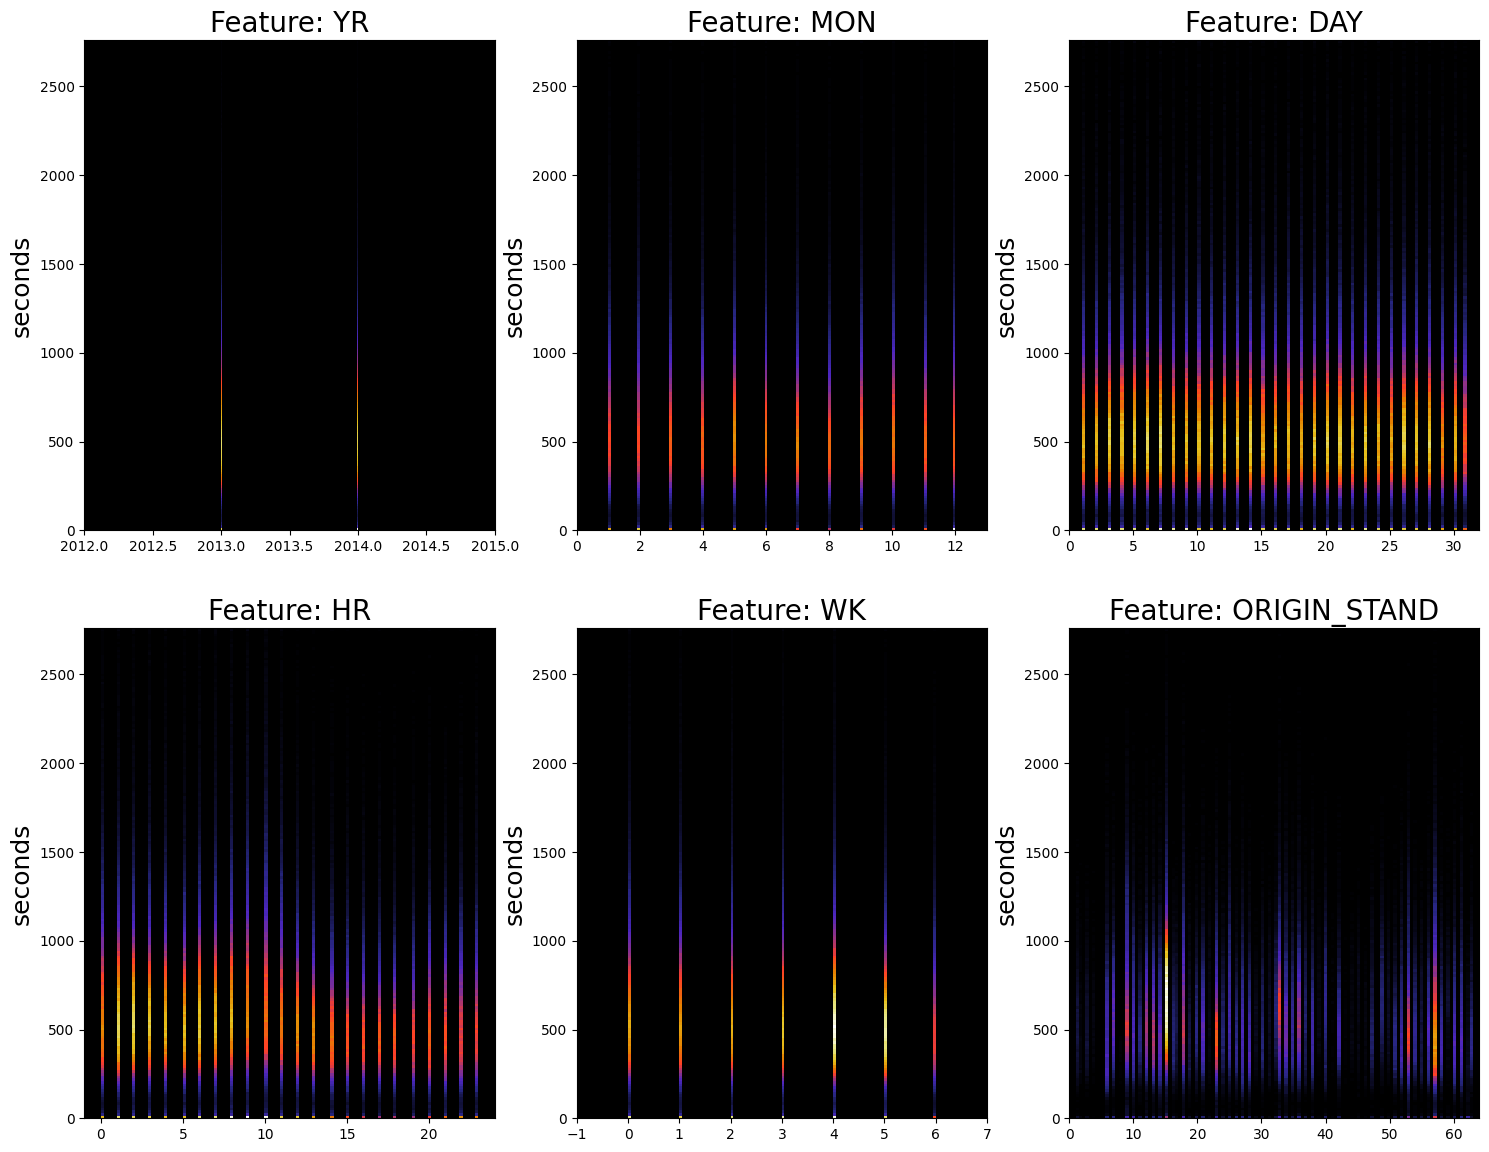

In [10]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


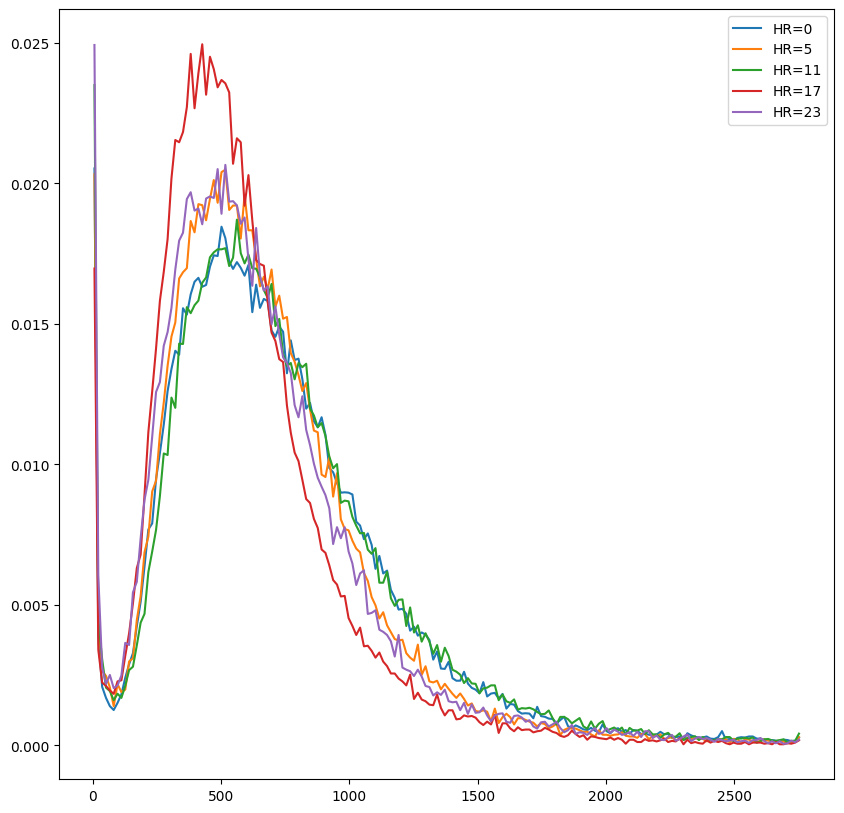

In [11]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend()

In [ ]:
df_tr

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


TRIP_ID: (String) - An unique identifier for each trip;

CALL_TYPE: (char) - Category of the ride. It may contain one of three possible values:
‘A’ if this trip was dispatched from the central
‘B’ if this trip was demanded directly to a taxi driver on a specific stand
‘C’ otherwise (i.e. a trip demanded on a random street)

ORIGIN_CALL: (integer) - An unique identifier for the phone number to call the taxi. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value; can get rid of

ORIGIN_STAND: (integer) - An unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value;

TAXI_ID: (integer) - An unique identifier for the taxi that performed each trip;

TIMESTAMP: (integer) - Unix Timestamp (in seconds). It identifies the trip’s start;

DAYTYPE: (char) - It identifies the daytype of the trip’s start. It assumes one of three possible values:
‘A’ if this trip started on a normal day or weekend
‘B’ if this trip started on a holiday or other special day
‘C’ if the trip started on a day before a type-B day

MISSING_DATA: (Boolean) - It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing

POLYLINE: (String): - A list of GPS coordinates (i.e. WGS84 format) mapped as a string. The beginning and the end of the string are identified with brackets (i.e. [ and ]). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. The coordinates were recorded every 15 seconds during the trip. The first item represents the starting point and the last item corresponds to the destination.